# Data Mining - Programming Project Task 1

## Approach & Results
See attached video.


## Setup

Clone [this repository](https://github.com/chrisonntag/imdb-analysis-copac) and install the required packages with pip from the ```requirements.txt``` file. We altered some 
of the code from the [TUDataset](https://github.com/chrsmrrs/tudataset) repo so that we don't have to deal with the correct version number of torch since we don't need torch for our uses anyway. 

Clone the repo.

```
git clone https://github.com/chrisonntag/imdb-analysis-copac.git
```
(or use some UI client)

Create a virtual environement. This creates a directory ```env/``` where all the dependencies will be installed.
```
python3 -m venv env
```

Choose the environment.
```
source env/bin/activate
```

Install all requirements.
```
pip install -r requirements.txt
```

Open Jupyter lab.
```
jupyter lab
```

Everything should work from hereon since all needed artifacts (e.g. the ELKI bundle) are part of this repo as well. 
You can find the data analysis notebook for the exploratory part and our COPAC implementation 
in ```/analysis/task1.ipynb```. 





## Utility functions

In [1]:
import os
import numpy as np
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
# from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from nrkmeans import NrKmeans
# import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from copy import deepcopy

In [2]:
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

In [3]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show();

In [4]:
base_path = os.path.join("../kernels", "without_labels")
ds_name = "IMDB-BINARY"
print(base_path)

../kernels\without_labels


In [5]:
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 1000
Number of classes 2


## Exploratory Data Analysis

### Feature Engineering

Choose desired gram matrix here.

#### Kernel

In [6]:
def get_gram_matrix(kernel_name, iterations=5):
    """
    Reads a gram matrix from the respective csv file.
    
    kernel_name: Name of the kernel (graphlet | shortestpath | wl)
    iterations (optional): Number of iterations for the Weisfeiler-Lehman subtree kernel
    """
    if kernel_name == 'wl':
        gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
    else:
        gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{kernel_name}.csv"))
        
    return aux.normalize_gram_matrix(gram)


def get_sparse_vectors(kernel_name, iterations=5):
    """
    Reads a sparse vector from the respective csv file.
    
    kernel_name: Name of the kernel (graphlet | shortestpath | wl)
    iterations (optional): Number of iterations for the Weisfeiler-Lehman subtree kernel
    """
    if kernel_name == 'wl':
        return load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{iterations}.npz"))
    else:
        return load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{kernel_name}.npz"))
        

In [7]:
gram = get_gram_matrix('wl', iterations=5)
vec = get_sparse_vectors('wl', iterations=5)

### Dimensionality Reduction

#### KernelPCA

In [8]:
kpca = KernelPCA(n_components=100, kernel="precomputed")
reduced_kpca = kpca.fit_transform(gram)

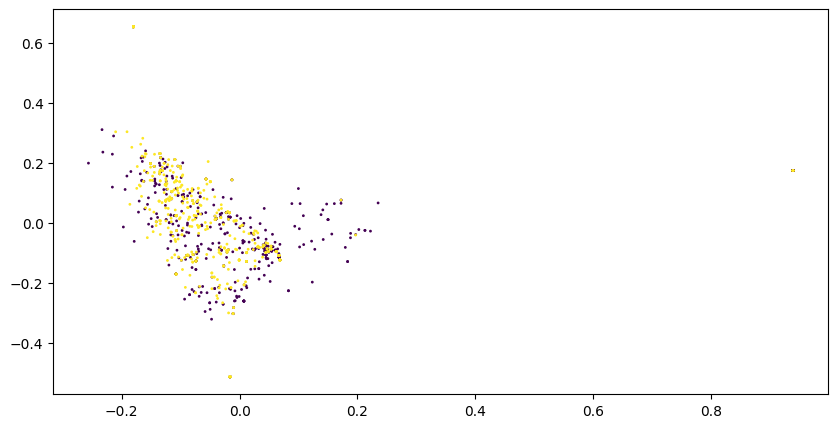

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(reduced_kpca[:,0], reduced_kpca[:,1], c=classes, s=1)
plt.show();

Some of these outliers might disturb some of the kmeans assumptions (variance).

#### Truncated SVD

In [10]:
tsvd = TruncatedSVD(n_components=100)
reduced_tsvd = tsvd.fit_transform(vec)

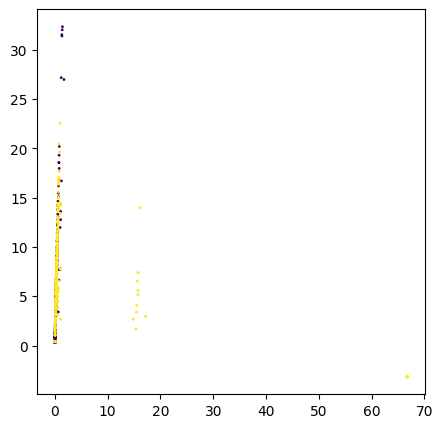

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(reduced_tsvd[:,0], reduced_tsvd[:,1], c=classes, s=1)
plt.show();

### Clustering

#### SubKMeans

In [12]:
k = len(set(classes.tolist()))
print("n_clusters: ", k)
nrkm = NrKmeans(n_clusters=[k,1], allow_larger_noise_space=True)
nrkm.fit(reduced_kpca, best_of_n_rounds=10, verbose=False)
print("Found Cluster Subspaces: ", nrkm.m)
subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
print(f"Subkmeans NMI:{subkm_nmi:.4f}") 

n_clusters:  2
Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0239


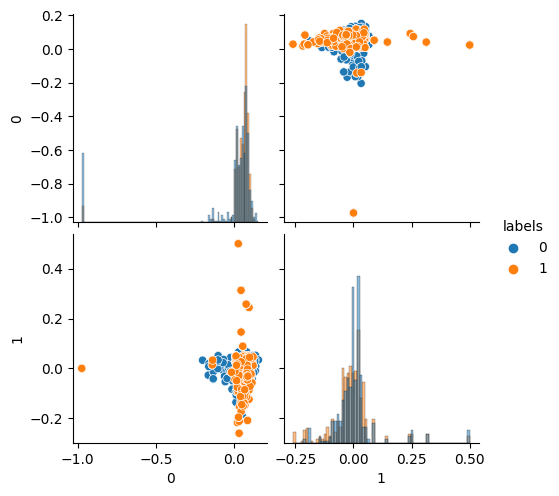

In [14]:
V = nrkm.V
rotated = np.dot(reduced_kpca,V)
reduced_df = pd.DataFrame(rotated[:,0:2])
reduced_df["labels"] = classes
sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
plt.show();

#### Spectral Clustering

In [22]:
base_path

'../kernels/without_labels'

#### Combined

In [39]:
print("Load from ", base_path)
nmis_kpca = {}
nmis_tsvd = {}
nmis_spec = {}

dataset = 'IMDB-BINARY'
classes = dp.get_dataset(ds_name)

nmis_kpca[dataset] = []
nmis_tsvd[dataset] = []
nmis_spec[dataset] = []

Load from  ../kernels/without_labels


Load from  ../kernels/without_labels
##################################
Dataset  IMDB-BINARY
Iteration  1
##################################
(1000, 1000) (1000, 4009)
n_clusters:  2
TSVD


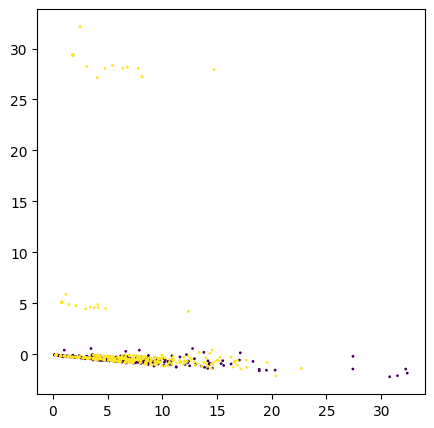

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0438


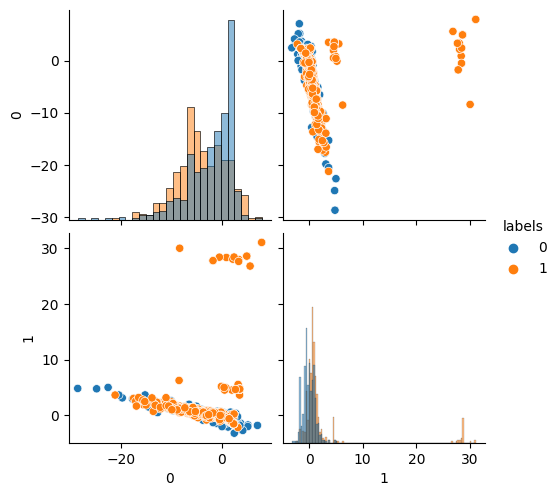

KPCA


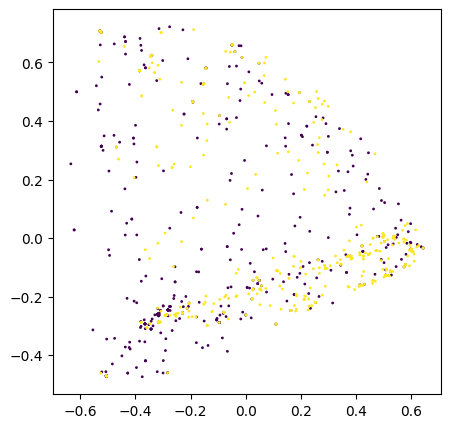

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0569


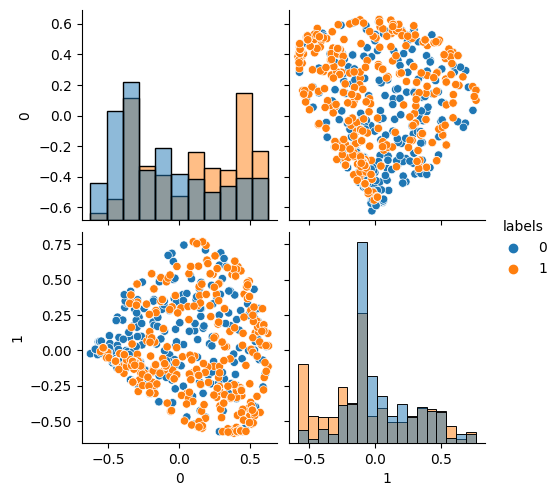

Spectral  NMI:0.0574
##################################
##################################
Dataset  IMDB-BINARY
Iteration  2
##################################
(1000, 1000) (1000, 8853)
n_clusters:  2
TSVD


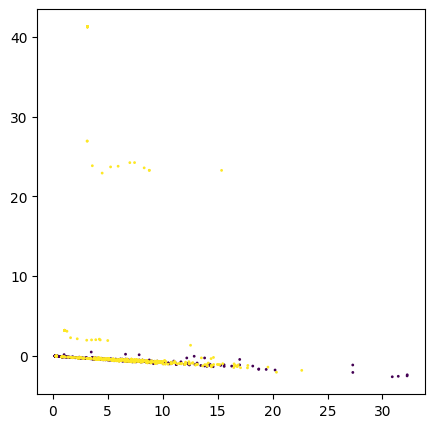

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0483


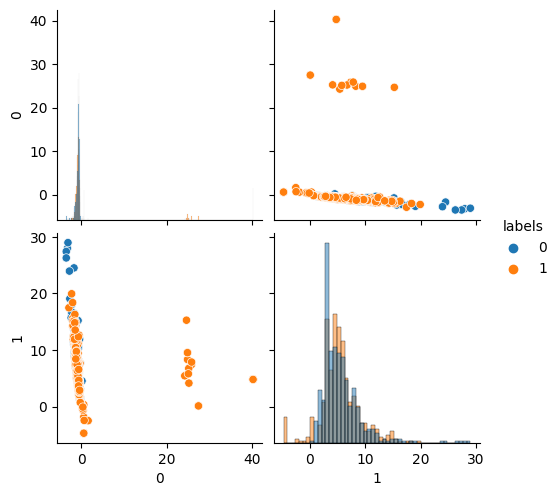

KPCA


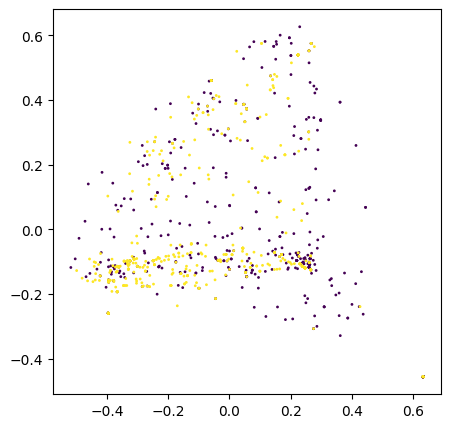

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0569


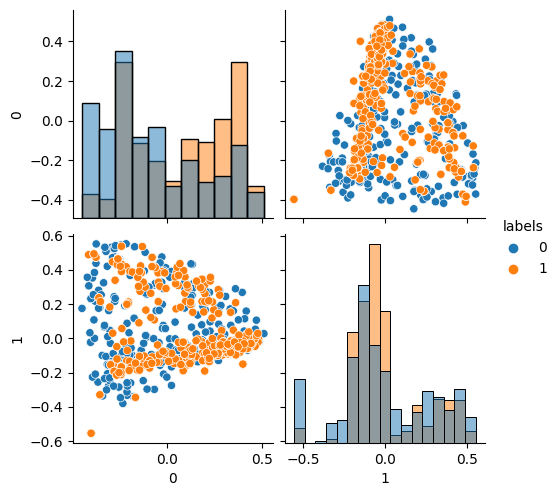

Spectral  NMI:0.0544
##################################
##################################
Dataset  IMDB-BINARY
Iteration  3
##################################
(1000, 1000) (1000, 13717)
n_clusters:  2
TSVD


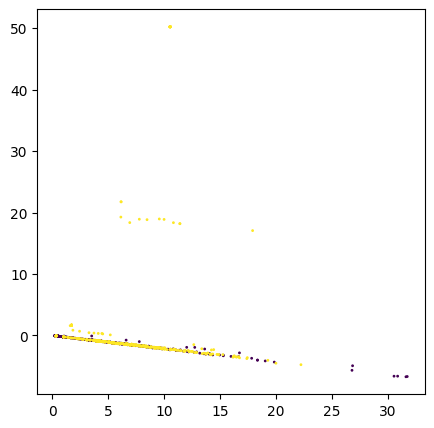

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0483


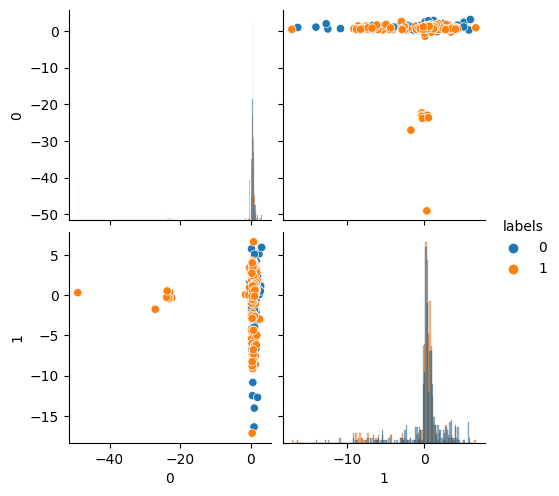

KPCA


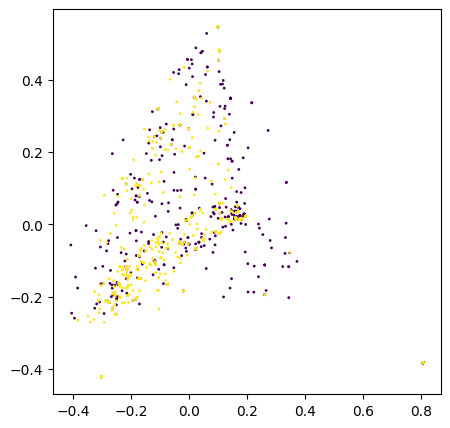

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0350


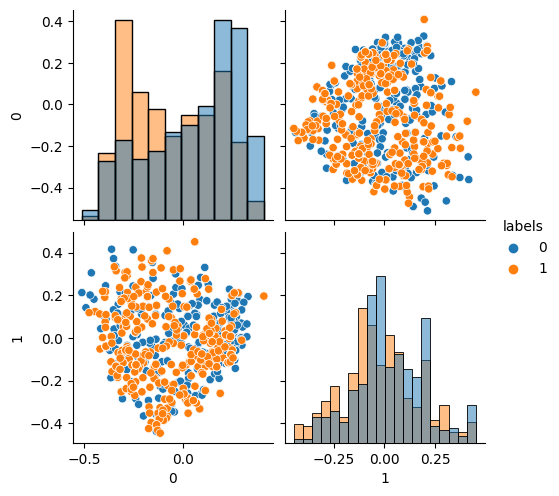

Spectral  NMI:0.0544
##################################
##################################
Dataset  IMDB-BINARY
Iteration  4
##################################
(1000, 1000) (1000, 18581)
n_clusters:  2
TSVD


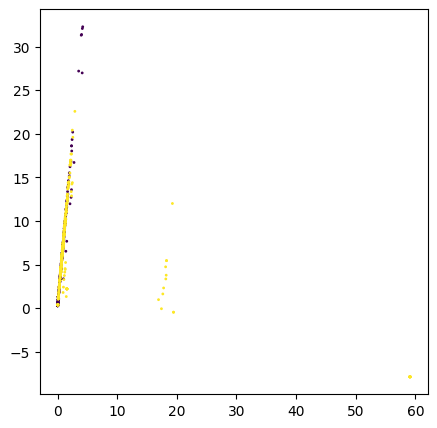

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0289


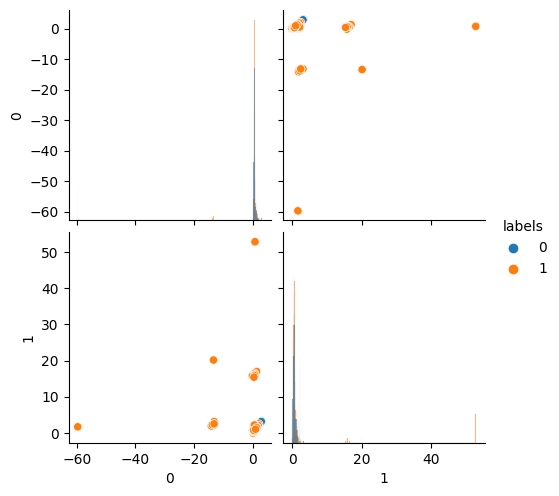

KPCA


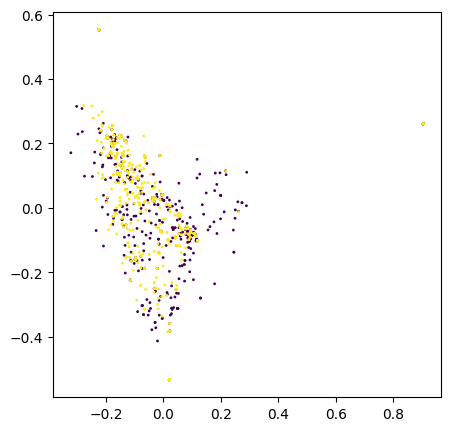

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0239


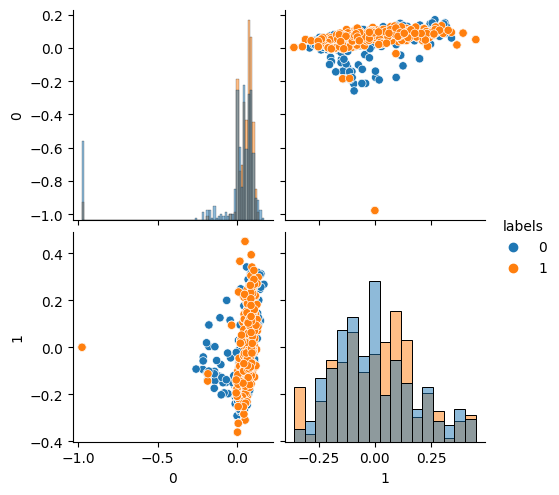

Spectral  NMI:0.0544
##################################
##################################
Dataset  IMDB-BINARY
Iteration  5
##################################
(1000, 1000) (1000, 23445)
n_clusters:  2
TSVD


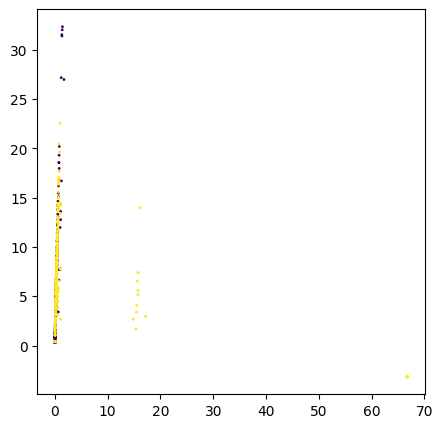

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0289


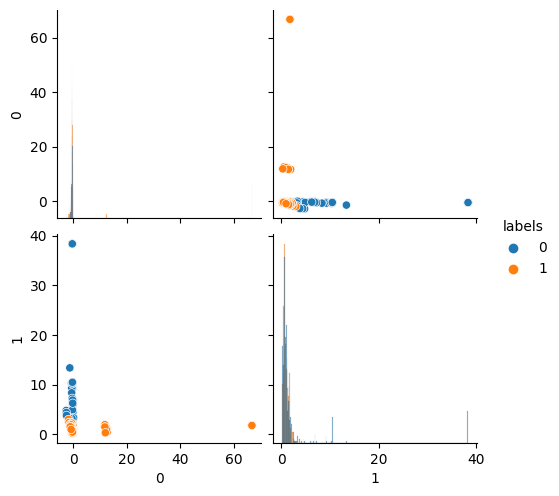

KPCA


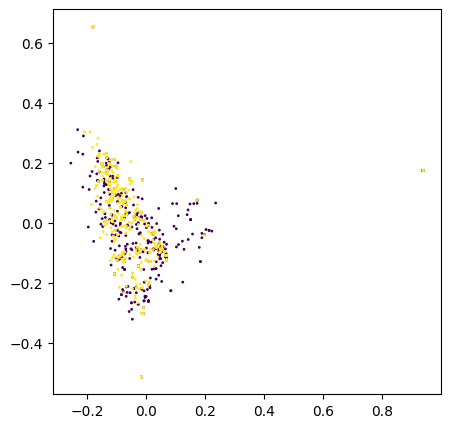

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0239


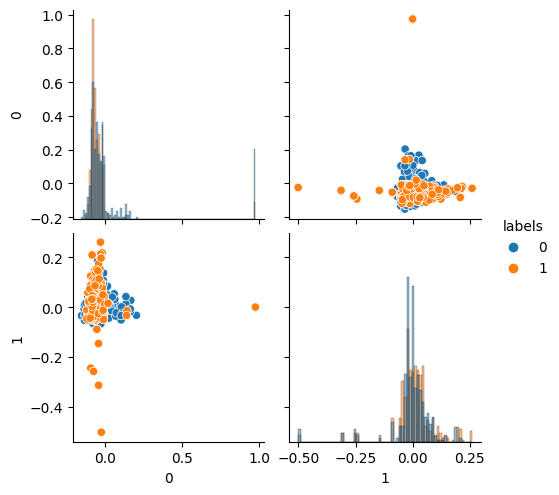

Spectral  NMI:0.0323
##################################


In [16]:
if not all([os.path.isfile(os.path.join(base_path, file + ".csv")) for file in ['KPCA', 'SPEC', 'TSVD']]):
    for iterations in range(1, 6):
        # 0 taking just the nodelabels themselves into account; 
        # 1 considers nearest-neighbours, 2 one layer deeper and so on
        # play with this parameter to create a new kernel!
        print("##################################")
        print("Dataset ", dataset)
        print("Iteration ", iterations)
        print("##################################")

        # Gram Matrix for the Weisfeiler-Lehman subtree kernel
        gram = get_gram_matrix('wl', iterations=iterations)

        # Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
        vec = get_sparse_vectors('wl', iterations=iterations)
        print(gram.shape, vec.shape)

        tsvd = TruncatedSVD(n_components=100)
        reduced_tsvd = tsvd.fit_transform(vec)

        kpca = KernelPCA(n_components=100, kernel="precomputed")
        reduced_kpca = kpca.fit_transform(gram)

        k = len(set(classes.tolist()))
        print("n_clusters: ", k)
        d = {0: "TSVD", 1: "KPCA"}
        n_d = {0: nmis_tsvd, 1: nmis_kpca}

        for i, rep_i in enumerate([reduced_tsvd, reduced_kpca]):
            print(d[i])

            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(rep_i[:,0], rep_i[:,1], c=classes, s=1)
            plt.show();

            # Apply Subkmeans
            nrkm = NrKmeans(n_clusters=[k,1])#, allow_larger_noise_space=False)
            nrkm.fit(rep_i, best_of_n_rounds=10, verbose=False)
            print("Found Cluster Subspaces: ", nrkm.m)
            subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
            print(f"Subkmeans NMI:{subkm_nmi:.4f}")    
            n_d[i][dataset].append(subkm_nmi)

            # Plot rotated space
            V = nrkm.V
            rotated = np.dot(rep_i,V)
            reduced_df = pd.DataFrame(rotated[:,0:2])
            reduced_df["labels"] = classes#nrkm.labels[0]
            sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
            plt.show();

        # Apply Spectral Clustering
        spec = SpectralClustering(n_clusters=k, affinity="precomputed")
        spec.fit(gram)
        spec_nmi = normalized_mutual_info_score(spec.labels_,classes)
        nmis_spec[dataset].append(spec_nmi)
        print(f"Spectral  NMI:{spec_nmi:.4f}")   

        print("##################################")

    res = {"KPCA": nmis_kpca, "TSVD": nmis_tsvd, "SPEC": nmis_spec}
    for key, value in res.items():
        nmi_df = pd.DataFrame(res[key])
        nmi_df.to_csv(os.path.join(base_path, key + ".csv"))

#### KMeans

In [25]:
# only keep the first 10 components to speed up computation
reduced_kpca_10 = reduced_kpca[:, 0:10]

Determine the number of k clusters

In [26]:
costs = []
kmeans_runs = []
k_list = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_kpca_10)
    costs.append(kmeans.inertia_)
    kmeans_runs.append(deepcopy(kmeans))

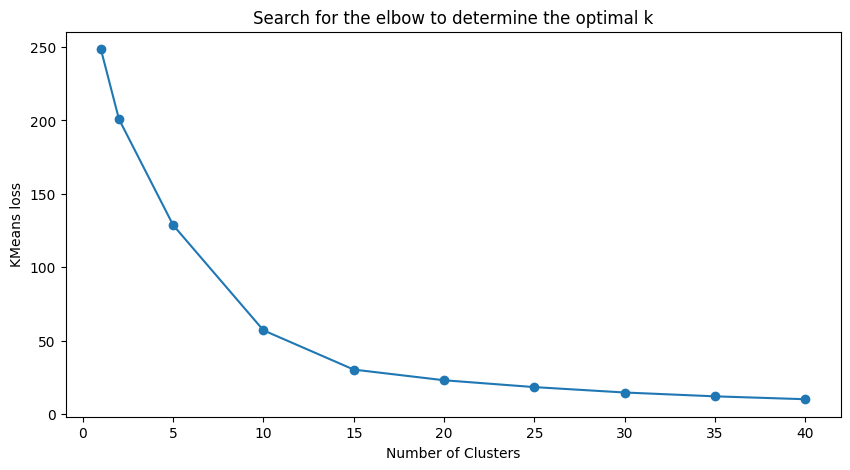

In [27]:
def scree_plot(k_list, costs):
    plt.figure(figsize=(10,5))
    plt.plot(k_list, costs, marker="o")
    plt.xlabel('Number of Clusters')
    plt.ylabel('KMeans loss')
    plt.title('Search for the elbow to determine the optimal k')
    plt.show();
scree_plot(k_list, costs)

We choose k=10

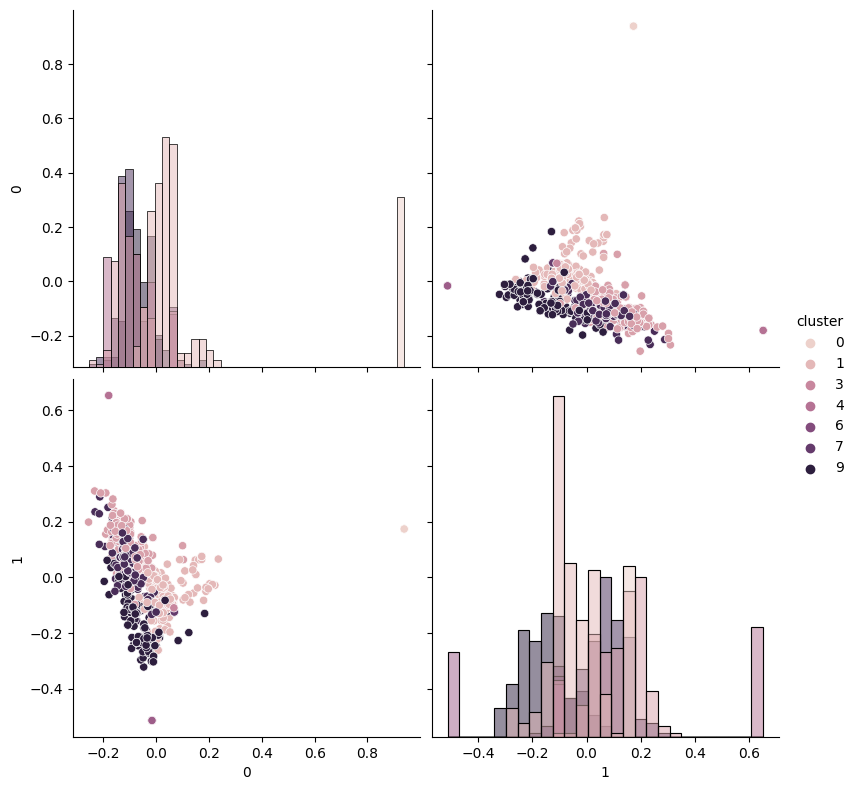

In [28]:
selected_idx = 3 # == k=10 in the kmeans_runs list
kmeans = kmeans_runs[selected_idx]
df = pd.DataFrame(reduced_kpca_10[:,0:2])
df["cluster"] = kmeans.labels_
sns.pairplot(df, hue="cluster", diag_kind="hist", height=4)
plt.show();

#### SubKMeans

### Outlier Detection

In [7]:
# tdb

### Visualization

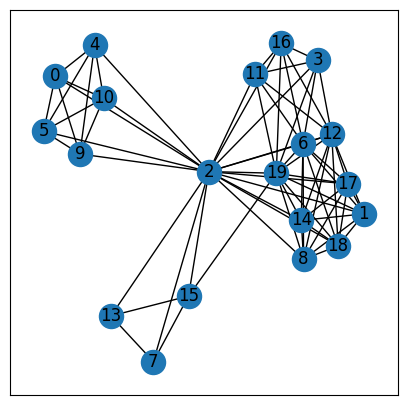

Graph with 20 nodes and 73 edges


In [26]:
# We just use the first in the list
idx = 0
visualize(G[idx])
print(G[0])

#### Plot n nearest neighbors of each centroid

In [29]:
from sklearn.metrics import pairwise_distances
# select first 2 nearest neighbours in for each cluster
nr_nearest = 2
nearest_indices = []
for cluster_i in set(kmeans.labels_):
    mask = (kmeans.labels_ == cluster_i)
    selection = reduced_kpca_10[mask]
    print(f"number of data points in cluster {cluster_i}: {selection.shape[0]}")
    center_i = kmeans.cluster_centers_[cluster_i].reshape(1,-1)
    distances_i = pairwise_distances(center_i, reduced_kpca_10)
    nearest_indices.append(np.argsort(distances_i, )[0][0:nr_nearest])
    print(f"Nearest data points in cluster {cluster_i}: {nearest_indices[-1]}")

number of data points in cluster 0: 48
Nearest data points in cluster 0: [ 54 249]
number of data points in cluster 1: 278
Nearest data points in cluster 1: [367 114]
number of data points in cluster 2: 192
Nearest data points in cluster 2: [523 959]
number of data points in cluster 3: 16
Nearest data points in cluster 3: [630 747]
number of data points in cluster 4: 31
Nearest data points in cluster 4: [ 58 532]
number of data points in cluster 5: 24
Nearest data points in cluster 5: [467 384]
number of data points in cluster 6: 15
Nearest data points in cluster 6: [166 121]
number of data points in cluster 7: 17
Nearest data points in cluster 7: [563 331]
number of data points in cluster 8: 197
Nearest data points in cluster 8: [701 547]
number of data points in cluster 9: 182
Nearest data points in cluster 9: [982 735]


In [24]:
#for i, indices in enumerate(nearest_indices):
#    print(f"Cluster {i}, Indices {indices}")
#    G_selected = select_from_list(G, indices)
#    for g_i in G_selected:
#        visualize(g_i)

#### NMI Comparison

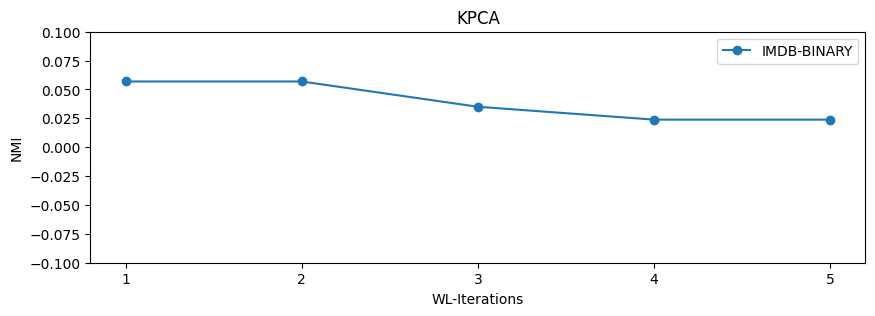

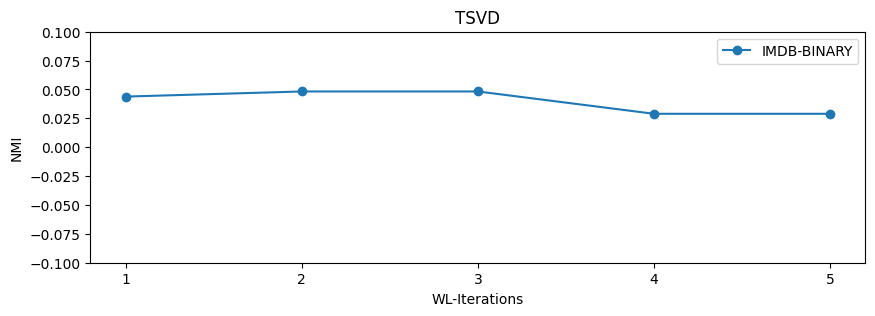

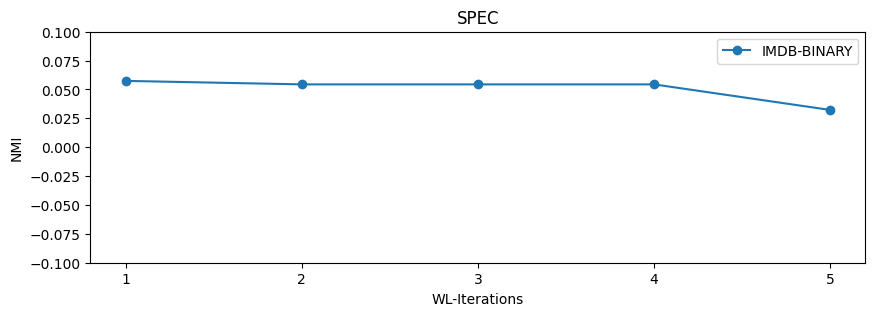

In [21]:
result_names = ["KPCA", "TSVD", "SPEC"]
for name_i in result_names:
    path_i = os.path.join(base_path, name_i+".csv")
    nmi_df = pd.read_csv(path_i, index_col=0)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.set_ylabel("NMI")
    ax.set_xlabel("WL-Iterations")
    ax.set_ylim([-0.1,0.1])
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_title(name_i)
    nmi_df.plot(marker="o", ax=ax)
    plt.show();

## COPAC

### ELKI Implementation

In [18]:
from elki import elki_copac

In [19]:
pred = elki_copac(reduced_kpca[:, 0:10], k=30, mu=15, eps=0.5, alpha=0.85) # TODO

Run elki


#### NMI

In [20]:
nmi = normalized_mutual_info_score(pred, classes)
print(f"NMI: {nmi:.4f}")

NMI: 0.0420


### Our Implementation

In [21]:
from copac_impl import copac

In [22]:
our_pred = copac(reduced_kpca[:, 0:10], k=30, mu=15, eps=0.5, alpha=0.85)

#### NMI

In [23]:
nmi = normalized_mutual_info_score(our_pred, classes)
print(f"NMI: {nmi:.4f}")

NMI: 0.0250


## Evaluation (COPAC on IMDB)

In [24]:
from sklearn import metrics

### Rand Index

https://scikit-learn.org/stable/modules/clustering.html#rand-index

In [25]:
rand_idx = metrics.rand_score(classes, our_pred)
print(f"Rand Index: {rand_idx:.4f}")

Rand Index: 0.5094


### NMI 

In [26]:
nmi = normalized_mutual_info_score(our_pred, classes)
print(f"NMI: {nmi:.4f}")

NMI: 0.0250


### Fowlkes-Mallows scores

In [27]:
fms = metrics.fowlkes_mallows_score(classes, our_pred)
print(f"FMS: {fms:.4f}")

FMS: 0.3958
